In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets
from tqdm.notebook import tqdm
import torchvision
from torch import nn
import os
import pickle
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import NUM_PTS, CROP_SIZE
from utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from utils import ThousandLandmarksDataset
from utils import restore_landmarks_batch, create_submission
import cv2
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
PATH='contest01_data'
EXP_NAME='test1'

In [4]:


def train(model, loader, loss_fn, optimizer, device,sheduler):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [5]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
])




In [6]:
train_dataset = ThousandLandmarksDataset(os.path.join(PATH, "train"), train_transforms, split="train")
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=6, pin_memory=False,
                              shuffle=False, drop_last=False)
val_dataset = ThousandLandmarksDataset(os.path.join(PATH, "train"), train_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=False,
                            shuffle=False, drop_last=False)

100%|██████████| 64001/64001 [00:05<00:00, 12748.55it/s] 


In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
model = torchvision.models.mobilenet_v2()
model.classifier = nn.Linear(1280,971*2,bias=True)

In [9]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [10]:

with open(os.path.join("runs", f"{EXP_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [11]:
# predictions = predict(model, train_dataloader, device)


In [30]:

def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    preds=[]
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        preds.extend(pred_landmarks)
        loss = loss_fn(pred_landmarks, landmarks,reduction='none')
        
        val_loss.extend(list(loss.detach().cpu().numpy()))

    return val_loss,preds

In [31]:
losses,preds = validate(model, train_dataloader, fnn.mse_loss, device)

validation...: 100%|██████████| 1600/1600 [01:05<00:00, 24.26it/s]


In [41]:
idxs = np.argsort(list(map(lambda x:x.mean(),losses)))[::-1]

In [68]:
import pandas as pd

In [ ]:
pd.DataFrame()

In [69]:
idxs

array([27363, 39530, 20925, ...,  8984, 24152, 32903])

In [71]:
pd.DataFrame(np.array(train_dataset.image_names)[idxs[:500]])

,0
0,contest01_data/train/images/a69558e1479aac67ba...
1,contest01_data/train/images/1c2c7ce3d36f61f1d8...
2,contest01_data/train/images/c3390bbeacfeebcf59...
3,contest01_data/train/images/45a9d96868ae01a98a...
4,contest01_data/train/images/8cc5121dca704359e1...
...,...
495,contest01_data/train/images/5285b2cea37616d16b...
496,contest01_data/train/images/33570fad1f59a43a09...
497,contest01_data/train/images/2d3530278c86fdde31...
498,contest01_data/train/images/a539d87c5be88fb3e3...


In [70]:
np.array(train_dataset.image_names)[idxs[:500]]

array(['contest01_data/train/images/a69558e1479aac67ba96809e31202507.jpg',
       'contest01_data/train/images/1c2c7ce3d36f61f1d850f162dbea7eca.jpg',
       'contest01_data/train/images/c3390bbeacfeebcf591b80622955288b.jpg',
       'contest01_data/train/images/45a9d96868ae01a98a4780564aa4d929.jpg',
       'contest01_data/train/images/8cc5121dca704359e1f9ed233917b6c8.jpg',
       'contest01_data/train/images/9f368da7433a3c050b9039ccfba83ec4.jpg',
       'contest01_data/train/images/19424f78a8d3c0786b295414e40511cf.jpg',
       'contest01_data/train/images/d623cd241c69eb2f53f01625fb34df1e.jpg',
       'contest01_data/train/images/c93291d476c5b0cd0f6ec408a7f5c148.jpg',
       'contest01_data/train/images/59fa8fb21b4757db2bbbbe195557f086.jpg',
       'contest01_data/train/images/2efbd2a717ff077c1debb8e8b3c25a3c.jpg',
       'contest01_data/train/images/346647ad4ccc5145285aa789ae931513.jpg',
       'contest01_data/train/images/f2558328604458f3bcef63a952bd1912.jpg',
       'contest01_data/tr

In [67]:
with open('my_shit.images',)

TypeError: Mismatch between array dtype ('<U64') and format specifier ('%.18e')

In [66]:
np.array(train_dataset.image_names)[idxs[:500]].savetxt('shit_images.my')

AttributeError: 'numpy.ndarray' object has no attribute 'savetxt'

In [42]:
idxs

array([27363, 39530, 20925, ...,  8984, 24152, 32903])

In [45]:
losses[27363].mean()

104.21041

In [24]:
idxs

array([1170,   15,   78, ...,   87, 1283, 1202])

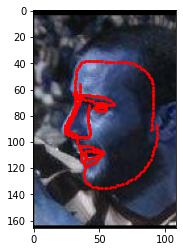

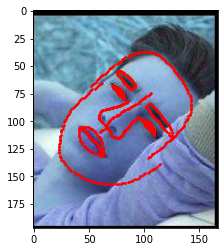

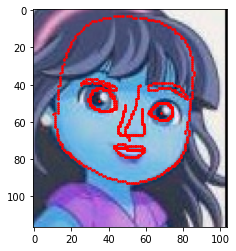

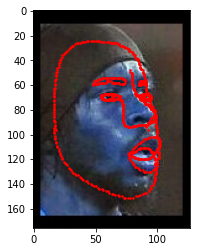

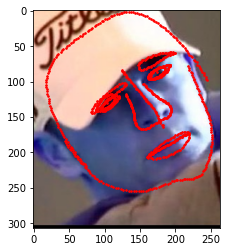

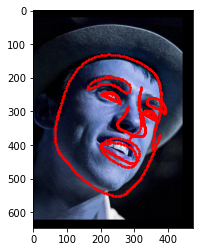

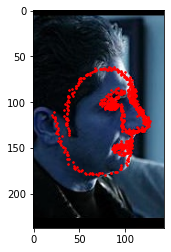

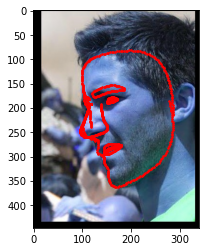

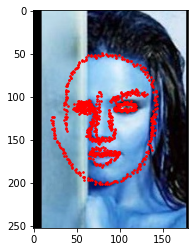

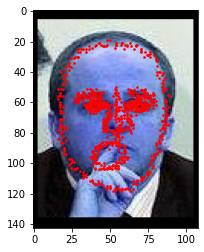

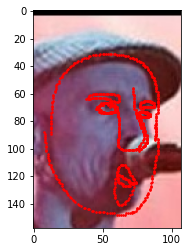

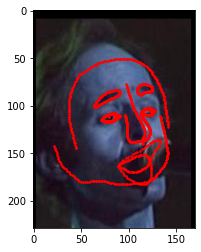

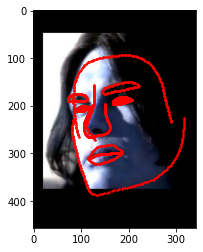

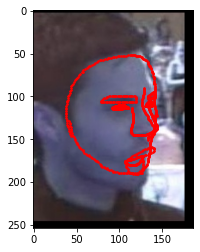

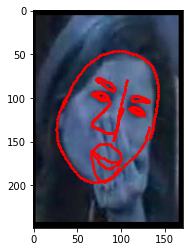

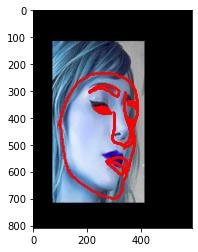

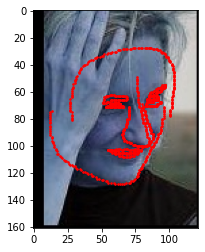

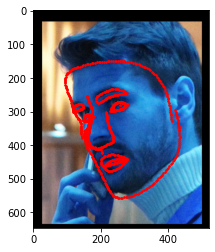

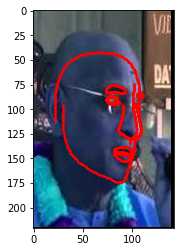

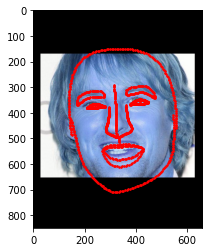

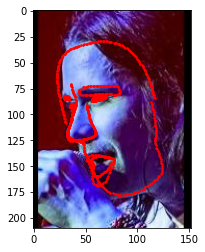

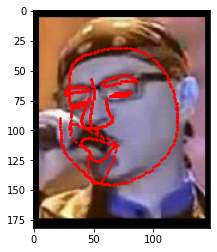

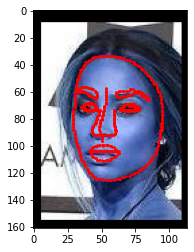

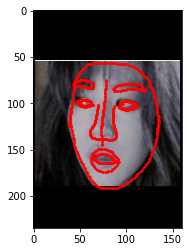

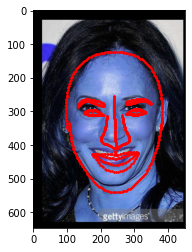

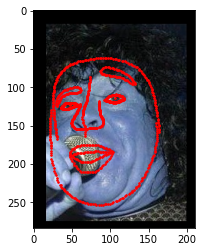

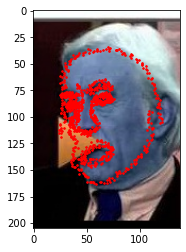

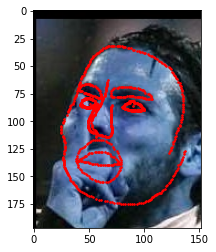

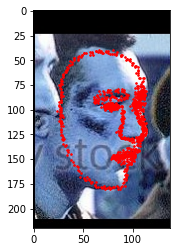

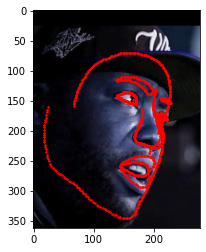

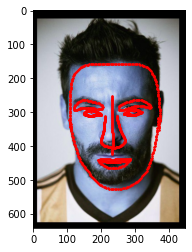

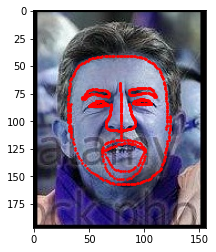

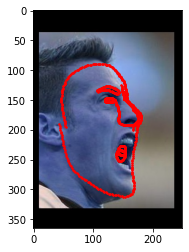

KeyboardInterrupt: 

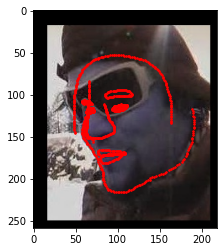

In [63]:
for idx in idxs[500:]:
    origin_image=cv2.imread(train_dataset.image_names[idx])
    origin_landmarks=train_dataset.landmarks[idx]
    sample = train_dataset[idx]
    plt.imshow(origin_image)
    plt.scatter(origin_landmarks[:, 0], origin_landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001) 
#     unscaled_predicitons =  model(sample['image'].unsqueeze(dim=0).to(device))[0].cpu().detach()
    

In [47]:
origin_image=cv2.imread(train_dataset.image_names[idx])
origin_landmarks=train_dataset.landmarks[idx]

In [48]:
sample = train_dataset[idx]

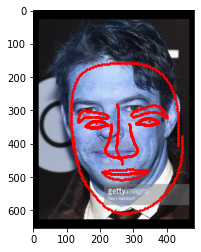

In [49]:
plt.imshow(origin_image)
plt.scatter(origin_landmarks[:, 0], origin_landmarks[:, 1], s=10, marker='.', c='r')

In [50]:
unscaled_predicitons =  model(sample['image'].unsqueeze(dim=0).to(device))[0].cpu().detach()

In [51]:
unscaled_predicitons

tensor([ 63.5789, 119.2208,  62.5127,  ...,  57.7576,  80.0353,  56.0820])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


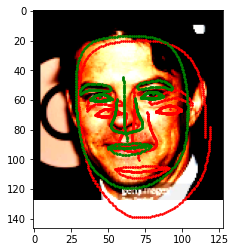

In [52]:
image = sample['image'].permute(1,2,0)
landmarks = torch.reshape(sample['landmarks'],(-1,2))
unscaled_predicitons =torch.reshape(unscaled_predicitons,(-1,2))
plt.imshow(image)
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
plt.scatter(unscaled_predicitons[:, 0], unscaled_predicitons[:, 1], s=10, marker='.', c='g')

In [32]:

def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks

In [33]:
scaled_predictions = restore_landmarks(unscaled_predicitons,sample['scale_coef'],(sample["crop_margin_x"],sample['crop_margin_y']))

In [34]:
scaled_predictions

tensor([[ 85.8916, 182.9622],
        [ 84.2767, 182.9473],
        [ 82.5472, 182.8571],
        ...,
        [ 69.7960, 145.6125],
        [ 66.1795,  94.6493],
        [113.1604,  95.7702]])

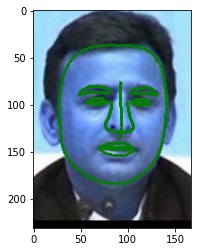

In [35]:
# image = sample['image'].permute(1,2,0)
# landmarks = torch.reshape(sample['landmarks'],(-1,2))
plt.imshow(origin_image)
# plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
plt.scatter(scaled_predictions[:, 0], scaled_predictions[:, 1], s=10, marker='.', c='g')

In [38]:
for i,sample in enumerate(train_loader):
    plt.imshow(sample['image'])
    plt.scatter(sample['landmarks'][:, 0], sample['landmarks'][:, 1], s=10, marker='.', c='r')
    plt.scatter(predictions[i][:, 0], predictions[i][:, 1], s=10, marker='.', c='g')

array([[[156.00482178, 310.29272461],
        [153.08830261, 310.46536255],
        [150.02159119, 310.69494629],
        ...,
        [125.36950684, 254.04606628],
        [117.67945862, 162.75827026],
        [195.44497681, 164.94415283]],

       [[ 90.65077209, 378.11288452],
        [ 88.26639557, 376.9052124 ],
        [ 86.15150452, 375.50289917],
        ...,
        [ 80.38822174, 306.34671021],
        [ 93.64878845, 203.6244812 ],
        [166.30662537, 204.57382202]],

       [[124.7726059 , 207.60127258],
        [123.02581024, 208.04019165],
        [120.85814667, 208.41796875],
        ...,
        [ 99.72007751, 174.79685974],
        [ 82.04914093, 117.82541656],
        [128.99511719, 110.75261688]],

       ...,

       [[ 78.01311493, 172.51542664],
        [ 76.66553497, 172.39465332],
        [ 75.34603882, 172.32991028],
        ...,
        [ 62.95048141, 143.41926575],
        [ 55.9883461 ,  97.21899414],
        [ 99.57504272,  94.88831329]],

       [[ 67.15